# Eye to Hand Calibration
- calculate transformation matrix from camera coordinate to robot base coordinate
- get around 20 images for calibration which have a chessboard wholely.
- method
    1. get translational and rotational relationship between camera and chessboard with cv2.solvePnP()
    2. calculate transformation matrix with cv2.calibrateHandeye()
- evaluation
    - test with reprojection rmse

## import library

### plot 3d rotation

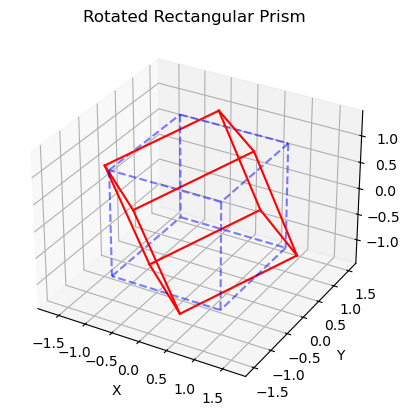

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy
import math

# Define the vertices of the rectangular prism (cube)
vertices = np.array([[1, 1, 1],
                     [1, -1, 1],
                     [-1, -1, 1],
                     [-1, 1, 1],
                     [1, 1, -1],
                     [1, -1, -1],
                     [-1, -1, -1],
                     [-1, 1, -1]])

# Define the edges connecting the vertices
edges = [[0, 1], [1, 2], [2, 3], [3, 0],
         [4, 5], [5, 6], [6, 7], [7, 4],
         [0, 4], [1, 5], [2, 6], [3, 7]]

# Define rotation angles in degrees
angles_deg = [0.32*180/math.pi,-2.979*180/math.pi,0.749*180/math.pi]

# Convert angles to radians
angles_rad = np.radians(angles_deg)

# Define rotation matrices
Rx = np.array([[1, 0, 0],
               [0, np.cos(angles_rad[0]), -np.sin(angles_rad[0])],
               [0, np.sin(angles_rad[0]), np.cos(angles_rad[0])]])

Ry = np.array([[np.cos(angles_rad[1]), 0, np.sin(angles_rad[1])],
               [0, 1, 0],
               [-np.sin(angles_rad[1]), 0, np.cos(angles_rad[1])]])

Rz = np.array([[np.cos(angles_rad[2]), -np.sin(angles_rad[2]), 0],
               [np.sin(angles_rad[2]), np.cos(angles_rad[2]), 0],
               [0, 0, 1]])

# Rotate vertices
rotated_vertices = vertices.dot(Rx).dot(Ry).dot(Rz)
rotation = scipy.spatial.transform.Rotation.from_euler(
            "XYZ",angles_deg, degrees=False #capitalized "XYZ" : extrinsic rotation, lower "xyz":intrinxic rotation"
        ).as_matrix()
#rotated_vertices = vertices.dot(rotation)

# Plot the rotated rectangular prism
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for edge in edges:
    ax.plot3D(vertices[edge, 0], vertices[edge, 1], vertices[edge, 2], 'b',linestyle="--",alpha=0.5)
    ax.plot3D(rotated_vertices[edge, 0], rotated_vertices[edge, 1], rotated_vertices[edge, 2], 'r')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_title('Rotated Rectangular Prism')

plt.show()

In [1]:
#import basic module
import os
import time
from ximea import xiapi
import cv2
import time
import numpy as np
import csv
import pandas as pd
from scipy import linalg
from scipy.spatial.transform import Rotation
import scipy
import glob
import math

import pose_estimation as pose
import handEye as he
import eval_handEye as eval

## 0. param setting

### camera params :: 20240405

In [2]:
BASELINE = 208 #
CHECKERBOARD = (3, 4)
CHECKERSIZE = 48  # [mm]
CRITERIA = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
IMG_SIZE = (640,640)
K_left = np.array([[754.66874569,0, 255.393104],[0, 754.64708568, 335.6848201], [0, 0, 1]])
K_right = np.array([[802.62616415,0, 286.48516862],[0, 802.15806832, 293.54957668], [0, 0, 1]])
dist_left = np.array([[-0.00661832 ,-0.19633213  ,0.00759942 ,-0.01391234 ,0.73355661]])
dist_right = np.array([[0.00586444 ,-0.18180071 , 0.00489287 ,-0.00392576  ,1.20394993]])
R0 = np.eye(3, dtype=np.float32)
T0 = np.array([0.0, 0.0, 0.0]).reshape((3, 1))
R1 = np.array([[ 0.98244287 ,-0.06210902  ,0.17592181],[0.08393148 ,0.98928591 ,-0.11945249], [-0.16661789,0.13212062,0.97712979]])
T1 = np.array([-510.97553847,251.62759119,-27.61766548]).reshape((3, 1))
RT_left = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0]])
RT_right = np.array([[ 0.9983483 ,  0.00312181, -0.05736654,-209.5785972], [-0.00260072,  0.9999547  , 0.00915595,-2.146], [ 0.05739252, -0.00899163,  0.9983112 ,-32.0618]])
# Projection matrices
P_left = np.dot(K_left, RT_left)
P_right = np.dot(K_left, RT_right)
print("projection matrix :: left=",P_left)
print("projection matrix :: right=",P_right)

projection matrix :: left= [[754.66874569   0.         255.393104     0.        ]
 [  0.         754.64708568 335.6848201    0.        ]
 [  0.           0.           1.           0.        ]]
projection matrix :: right= [[ 7.68079913e+02  5.95321413e-02  2.11669061e+02 -1.66350780e+05]
 [ 1.73031720e+01  7.51594546e+02  3.42027427e+02 -1.23821322e+04]
 [ 5.73925200e-02 -8.99163000e-03  9.98311200e-01 -3.20618000e+01]]


### robot params :: 20240405

In [3]:
#0405 data
robot1 = [-259.34,509.51,741.9,0.054,-3.319,1.012]
robot2 = [-155.08,471.37,771.06,0.172,-3.158,0.958]
robot3 = [-115.99,451.34,794.47,0.194,-3.117,0.884]
robot4 = [-9.31,465.92,826.15,0.16,2.976,-0.856]
robot5 = [-8.71,465.23,836.7,0.165,2.912,-1.075]
robot6 = [72.73,603.8,805.73,0.478,-2.998,0.724]
robot7 = [-57.78,478.1,676.37,0.269,-2.826,0.781]
robot8 = [37.42,521.98,834.64,0.145,-3.074,0.958]
robot9 = [54.96,554.28,891.54,0.379,-3.107,1.087]
robot10= [-99.68,551.11,877.56,0.322,2.476,-1.054]
robot11 = [-314.55,463.32,877.57,0.278,-3.491,1.273]
robot12 = [-281.71,498.97,782.45,0.754,-3.243,0.932]
robots = np.array([robot1,robot2,robot3,robot4,robot5,robot6,robot7,robot8,robot9,robot10,robot11,robot12])

## 1. calculate chessboard pose to camera

### param setting

In [4]:
#20240109
#SRC = r"C:\Users\kawaw\data_tracking\20240109\calibration\eyeHand"
#20240405
SRC = r"C:\Users\kawaw\data_tracking\calibration\0405\eyeHand"
SRC = r"C:\Users\kawaw\data_tracking\0411\eyeHand"
leftSrc = os.path.join(SRC,"left")
rightSrc = os.path.join(SRC,"right")
BASELINE=208
cam_left_param = [K_left, dist_left, R0, T0]
cam_right_param = [K_right, dist_right, R1, T1]
CHECKERSIZE = 48
CHECKERBOARD = (4,3) #20240405 : (4,3), 20240109: (3,4)

pe = pose.PoseEstimation(checkerBoard=CHECKERBOARD,checkersize=CHECKERSIZE)

construct Chessboard pose estimation class


In [5]:
matrix = np.array([[1, 2, 3],
                   [4, 5, 6],
                   [7, 8, 9]])
print(matrix.transpose(1,0))

[[1 4 7]
 [2 5 8]
 [3 6 9]]


In [27]:
#undistort imgs
undistort_img_saveDir_left = pe.undistortImg(leftSrc,K_left,dist_left)
undistort_img_saveDir_right = pe.undistortImg(rightSrc,K_right,dist_right)
#calculate chessboard's pose against camera
imgsPath = [os.path.join(undistort_img_saveDir_left,f) for f in os.listdir(undistort_img_saveDir_left) if os.path.isfile(os.path.join(undistort_img_saveDir_left, f))]
transMats = np.zeros((len(imgsPath),4,4))
#print(len(imgsPath))
counter = 0
image_files = []
image_files = glob.glob(f'{undistort_img_saveDir_left}/*.png')
print(len(image_files))
for file in image_files:
    transMat = pe.getPose(cameraMatrix=K_left,dist=dist_left,src=file,rootDir=undistort_img_saveDir_left,center_based=False,debug=True,boolReverse=False) #20240109 -> boolReverse=False, 20240405->True,20240411->False
    #print(transMat.shape)
    transMats[counter] = transMat #T_cam2target
    #print(f"{counter} :: {transMat}")
    counter+=1
print(transMats.shape)
R_cam2target = np.zeros((transMats.shape[0],3,3))
T_cam2target = np.zeros((transMats.shape[0],3))
H_cam2target = np.zeros((transMats.shape[0],4,4))
#target2gripper
T_target2gripper = np.zeros((4,4))
T_target2gripper[2,0] = 1 #-1
T_target2gripper[0,1] = -1
T_target2gripper[1,2] = -1
T_target2gripper[3,3] = 1
for i in range(transMats.shape[0]):
    transMats[i] = np.matmul(transMats[i],T_target2gripper)
    R_cam2target[i] = transMats[i,:3,:3]
    T_cam2target[i] = transMats[i,:3,3]
    H_cam2target[i,:3,:3] = transMats[i,:3,:3]
    H_cam2target[i,:3,3] = transMats[i,:3,3]
    H_cam2target[i][3][3] = 1
print(R_cam2target)
print(T_cam2target)

10
10
10
(12, 1, 2)
corners2=
 [[[469.13657 521.9501 ]]

 [[414.92084 514.12616]]

 [[362.36804 506.30765]]

 [[311.0457  499.6249 ]]

 [[472.65836 470.75375]]

 [[420.00092 463.90918]]

 [[368.87238 457.07333]]

 [[319.27148 451.24005]]

 [[476.02106 422.65015]]

 [[425.16458 416.40298]]

 [[375.1184  410.52032]]

 [[326.69235 405.4233 ]]] 

objp=
 [[  0.   0.   0.]
 [  0.  48.   0.]
 [  0.  96.   0.]
 [  0. 144.   0.]
 [ 48.   0.   0.]
 [ 48.  48.   0.]
 [ 48.  96.   0.]
 [ 48. 144.   0.]
 [ 96.   0.   0.]
 [ 96.  48.   0.]
 [ 96.  96.   0.]
 [ 96. 144.   0.]] 

[[[472.63644 470.53638]]

 [[415.00076 514.22876]]

 [[473.67792 505.37796]]]
(12, 1, 2)
corners2=
 [[[543.2584  516.3389 ]]

 [[483.29105 504.64307]]

 [[425.89648 493.72415]]

 [[371.26736 483.76633]]

 [[549.4294  461.95895]]

 [[491.40082 451.7811 ]]

 [[435.5684  442.32025]]

 [[382.20364 433.59003]]

 [[555.4678  410.51483]]

 [[498.96194 402.0614 ]]

 [[444.4317  393.5472 ]]

 [[392.6688  386.0936 ]]] 

objp=
 [[  0.  

## 2. Calculate transform matrix from camera coordinate to robot base

### robot pose

In [28]:
R_base2gripper = np.zeros((robots.shape[0],3,3))
T_base2gripper = np.zeros((robots.shape[0],3))
H_base2gripper = np.zeros((robots.shape[0],4,4))
for j in range(robots.shape[0]):
    R,T = he.pose2matrix(pose=robots[j])
    #print(R,R.T)
    R_base2gripper[j] = R
    T_base2gripper[j] = T
    H_base2gripper[j,:3,:3] = R
    H_base2gripper[j,:3,3] = T
    H_base2gripper[j][3][3] = 1
#print(H_base2gripper)
print(R_base2gripper,T_base2gripper)

[[[-0.88219108 -0.18342589  0.43369786]
  [-0.15661161  0.98287308  0.09712523]
  [-0.44408524  0.0177609  -0.89580849]]

 [[-0.85721125 -0.24742316  0.45163109]
  [-0.16476184  0.96268725  0.21467836]
  [-0.48789589  0.10961313 -0.86599224]]

 [[-0.91601611 -0.08174137  0.39272488]
  [-0.02582702  0.98900491  0.14560996]
  [-0.40030919  0.12323816 -0.90805557]]

 [[-0.92340461  0.01939435  0.38333769]
  [ 0.09486212  0.97927163  0.17896437]
  [-0.37192083  0.20162075 -0.90610373]]

 [[-0.90132077  0.13437805  0.41178078]
  [ 0.23315167  0.95170215  0.19975815]
  [-0.36504954  0.27605355 -0.88911938]]

 [[-0.82981443 -0.30478806  0.46745294]
  [-0.33904261  0.94070083  0.01149191]
  [-0.44323597 -0.14895031 -0.88394326]]

 [[-0.93231415 -0.12663264  0.33875435]
  [-0.02829964  0.95936572  0.28074283]
  [-0.36054052  0.25215389 -0.89801389]]

 [[-0.75581977 -0.44081945  0.4841639 ]
  [-0.44293321  0.88878678  0.11776347]
  [-0.4822309  -0.12544431 -0.8670162 ]]

 [[-0.64717816  0.571063

### Method1. eye-to-hand calibration

In [29]:
R_cam2base,T_cam2base = he.calibrate_eye_hand(R_gripper2base=R_base2gripper,t_gripper2base=T_base2gripper,R_target2cam=R_cam2target,t_target2cam=T_cam2target,eye_to_hand=True)
H_cam2base = np.eye(4)
H_cam2base[:3,:3] = R_cam2base
H_cam2base[:3,3] = T_cam2base.reshape(3)
print(H_cam2base)

rotation matrix =  [[ 0.71955504 -0.39208867  0.57315532]
 [ 0.54977628  0.82587039 -0.12523635]
 [-0.42424825  0.40522164  0.80982025]] 
translation = [[ 357.70404344]
 [1162.76881638]
 [ -66.29319625]]
[[ 7.19555044e-01 -3.92088668e-01  5.73155315e-01  3.57704043e+02]
 [ 5.49776283e-01  8.25870387e-01 -1.25236346e-01  1.16276882e+03]
 [-4.24248250e-01  4.05221644e-01  8.09820253e-01 -6.62931963e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


### Manual version

In [41]:
H_cam2base = np.array([[0,0,-1,-600],[1,0,0,300],[0,-1,0,-800],[0,0,0,1]])

## 4. Evaluation

### param setting

In [42]:
#SRC = r"C:\Users\kawaw\data_tracking\20240109\calibration\eyeHand"
SRC = r"C:\Users\kawaw\data_tracking\calibration\0405\eyeHand"
SRC = r"C:\Users\kawaw\data_tracking\0411\eyeHand"
METHOD = "triangulation-mean" #"triangulation","triangulation-mean", "dlt", "library"
leftSrc = os.path.join(SRC,"left")
rightSrc = os.path.join(SRC,"right")

In [43]:
#prepare storage
imgsPath_left = [os.path.join(leftSrc,f) for f in os.listdir(leftSrc) if os.path.isfile(os.path.join(leftSrc, f))]
pts_left = np.zeros((len(imgsPath_left),2))
imgsPath_right = [os.path.join(rightSrc,f) for f in os.listdir(rightSrc) if os.path.isfile(os.path.join(rightSrc, f))]
pts_right = np.zeros((len(imgsPath_right),2))
#get corners from chessboard
counter = 0
for file in imgsPath_left:
    pt = eval.getCorner(K_left,dist_left,file,leftSrc,checkerBoard=CHECKERBOARD,checkersize=CHECKERSIZE,debug=True,boolReverse=False) #20240405 : boolReverse=True,,20240411,20240109 : boolReverse=False
    pts_left[counter] = pt
    counter += 1
counter = 0
for file in imgsPath_right:
    pt = eval.getCorner(K_right,dist_right,file,rightSrc,checkerBoard=CHECKERBOARD,checkersize=CHECKERSIZE,debug=True,boolReverse=False) #20240405 : boolReverse=True, 20240411,20240109 : boolReverse=False
    pts_right[counter] = pt 
    counter += 1
#get 3d points
pts3D = np.zeros((pts_left.shape[0],3))
counter = 0
for pt_left,pt_right in zip(pts_left,pts_right):
    pt_3d = eval.triangulate(left=pt_left,right=pt_right,K_left=K_left,K_right=K_right,dist_left=dist_left,dist_right=dist_right,R0=R0,T0=T0,R1=R1,T1=T1,baseline=BASELINE,method=METHOD)
    pts3D[counter] = pt_3d
    counter+=1
#transform from camera to robot base coordinate
pts_robotBase = np.zeros((pts3D.shape[0],3))
for i in range(pts3D.shape[0]):
    pose_cam = np.ones(4)
    pose_cam[:3] = pts3D[i]
    pt = np.matmul(H_cam2base,pose_cam)
    print("estimation=",pt)
    print("true=",robots[i])
    pts_robotBase[i] = pt[:3]
#calculate RMSE
pos_robot = np.zeros((robots.shape[0],3))
for i in range(robots.shape[0]):
    pos_robot[i] = robots[i][:3]
eval.rmse(pos_gt=pos_robot,pos_est=pts_robotBase)

C:\Users\kawaw\data_tracking\0411\eyeHand\left\1.png
C:\Users\kawaw\data_tracking\0411\eyeHand\left\10.png
C:\Users\kawaw\data_tracking\0411\eyeHand\left\2.png
C:\Users\kawaw\data_tracking\0411\eyeHand\left\3.png
C:\Users\kawaw\data_tracking\0411\eyeHand\left\4.png
C:\Users\kawaw\data_tracking\0411\eyeHand\left\5.png
C:\Users\kawaw\data_tracking\0411\eyeHand\left\6.png
C:\Users\kawaw\data_tracking\0411\eyeHand\left\7.png
C:\Users\kawaw\data_tracking\0411\eyeHand\left\8.png
C:\Users\kawaw\data_tracking\0411\eyeHand\left\9.png
C:\Users\kawaw\data_tracking\0411\eyeHand\right\1.png
C:\Users\kawaw\data_tracking\0411\eyeHand\right\10.png
C:\Users\kawaw\data_tracking\0411\eyeHand\right\2.png
C:\Users\kawaw\data_tracking\0411\eyeHand\right\3.png
C:\Users\kawaw\data_tracking\0411\eyeHand\right\4.png
C:\Users\kawaw\data_tracking\0411\eyeHand\right\5.png
C:\Users\kawaw\data_tracking\0411\eyeHand\right\6.png
C:\Users\kawaw\data_tracking\0411\eyeHand\right\7.png
C:\Users\kawaw\data_tracking\0411\ey